In [388]:
import numpy as np
from numpy import typing as npt
from numpy import random as rnd
from collections.abc import Callable, Sequence
from pyclugen import clugen
import matplotlib.pyplot as plt

In [389]:
def sigm(x: float):
    return 1.0 / (1 + np.exp(-x))

vsigm = np.vectorize(sigm)


In [390]:
def infer(input: npt.NDArray, nn: list[npt.NDArray]) -> list[npt.NDArray]:

    output = [input]

    for layer in range(len(nn)):
        input = np.hstack((1, output[layer]))
        output.append(vsigm(input @ nn[layer]))

    return output


In [391]:
def avgfitness(expected: npt.NDArray, actual: npt.NDArray) -> float:
    correct = np.sum(np.apply_along_axis(np.all, 1, actual == expected))
    return correct / expected.shape[0]

In [392]:
def backpropagation(train_input: npt.NDArray, train_output: npt.NDArray, topol: Sequence[int], iters: int, eta: float, seed: int=123):

    rng = rnd.default_rng(seed)

    # Create fully connected feed-forward network
    nn = []
    for j in range(len(topol) - 1):
        nn.append(rng.uniform(low=-0.05, high=0.05, size=(topol[j] + 1, topol[j + 1])))

    # Fitnesses
    fitnesses = np.zeros(iters) 
    
    # Train!
    for i in range(iters):

        for j in range(train_input.shape[0]):

            err = []

            output = infer(train_input[j, :], nn)

            #err.insert(0, output[-1] * (1 - output[-1]) * (train_output[j, :] - output[-1]))
            e = np.zeros(topol[-1])
            for k in range(topol[-1]):
                ok = output[-1][k]
                e[k] = ok * (1 - ok) * (train_output[j, k] - ok)
            err.insert(0, e)

            for layer in np.arange(len(nn) - 1, 0, -1):
                # o = output[layer]
                # sumult = nn[layer][1:, :] @ err[0]
                # err.insert(0, o * (1 - o) * sumult)
                e = np.zeros(topol[layer])
                for h in range(topol[layer]):
                    oh = output[layer][h]
                    e[h] = oh * (1 - oh) * np.sum(nn[layer][h, :] * err[0])
                err.insert(0, e) 

            print(err)
            for layer in range(len(nn)):
                #nn[layer] += eta * err[layer].reshape((1, -1)) @ output[layer + 1].reshape((-1, 1))
                for i_ji in range(nn[layer].shape[0]):
                    for j_ji in range(nn[layer].shape[1]):
                        nn[layer][i_ji, j_ji] += eta * err[layer][j_ji] * np.hstack((1, output[layer]))[i_ji]

        # Determine fitness after current iteration        
        clusters_nn_inferred = np.zeros(train_output.shape)
        for j in range(clusters_nn_inferred.shape[0]):
            result = np.round(infer(train_input[j, :], nn)[-1])
            clusters_nn_inferred[j, np.argmax(result)] = 1
            
        fitnesses[i] = avgfitness(train_output, clusters_nn_inferred)

    return nn, fitnesses

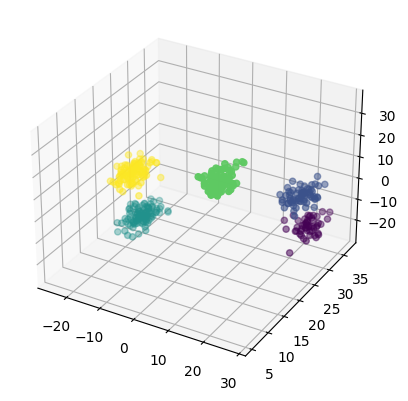

In [393]:
# Create some data with pyclugen
ndims = 3
seed = 123
nclu = 5
numpoints = 400

data = clugen(
    ndims,
    nclu,
    numpoints,
    [1, 1, 0.5],
    np.pi / 4,
    [15, 15, 15],
    0.1,
    0,
    2,
    point_dist_fn="n",
    rng=rnd.default_rng(seed),
)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(data.points[:, 0], data.points[:, 1], data.points[:, 2], c=data.clusters)
plt.show()

In [394]:
iters = 50
eta = 0.0001

# Convert output to appropriate NN format output
clusters_nn = np.zeros((numpoints, nclu))
for j in range(numpoints):
    clusters_nn[j, data.clusters[j]] = 1

nn, fitnesses = backpropagation(data.points, clusters_nn, [ndims, 7, nclu], iters, eta)

[array([-0.00057575, -0.00076898,  0.0004888 ,  0.00530255,  0.00236659,
       -0.00153308, -0.00129903]), array([ 0.12179733, -0.12667979, -0.12172951, -0.12831297, -0.12056398])]
[array([-0.00059395, -0.00070644,  0.0003962 ,  0.00523018,  0.00249901,
       -0.00144851, -0.00116202]), array([ 0.12184824, -0.12666548, -0.121753  , -0.12826541, -0.12045032])]
[array([-0.00060013, -0.00069571,  0.00041167,  0.00531595,  0.00253306,
       -0.00141164, -0.0011389 ]), array([ 0.12188752, -0.12667539, -0.12169288, -0.1282293 , -0.12033685])]
[array([-0.00058914, -0.00073597,  0.00043769,  0.00523933,  0.00250055,
       -0.00149342, -0.00125168]), array([ 0.12181922, -0.12664427, -0.12176165, -0.12825834, -0.12050515])]
[array([-0.00063567, -0.00066661,  0.000352  ,  0.0050946 ,  0.0028722 ,
       -0.00139184, -0.00117682]), array([ 0.12193017, -0.12657745, -0.12185055, -0.12810648, -0.12033372])]
[array([-0.00062168, -0.00071178,  0.00045516,  0.00532623,  0.00274995,
       -0.0014264

[array([-1.26226254e-04, -4.16560099e-03, -6.60799110e-05,  2.82622672e-03,
        4.87459968e-04, -1.09159432e-03, -9.48881623e-04]), array([-0.12757548, -0.12605313,  0.12841521, -0.12787548, -0.1213916 ])]
[array([-1.08588337e-04, -4.07692983e-03, -6.27901247e-05,  2.83879472e-03,
        3.94049137e-04, -1.05313375e-03, -9.47647902e-04]), array([-0.12768131, -0.12604362,  0.12834614, -0.12793369, -0.12156389])]
[array([-1.19237518e-04, -4.14296682e-03, -6.16625545e-05,  2.83632307e-03,
        4.61685965e-04, -1.06751185e-03, -9.46520999e-04]), array([-0.12766844, -0.1259701 ,  0.12833644, -0.12784176, -0.12147364])]
[array([-1.20387436e-04, -4.13848531e-03, -6.27406864e-05,  2.83778359e-03,
        4.74363765e-04, -1.07586325e-03, -9.51019961e-04]), array([-0.12760151, -0.12602749,  0.12837928, -0.12787387, -0.12144214])]
[array([-1.07073061e-04, -4.03846498e-03, -6.04970406e-05,  2.83688871e-03,
        4.05256263e-04, -1.04386643e-03, -9.61099595e-04]), array([-0.12764655, -0.1

Text(0, 0.5, 'Fitness')

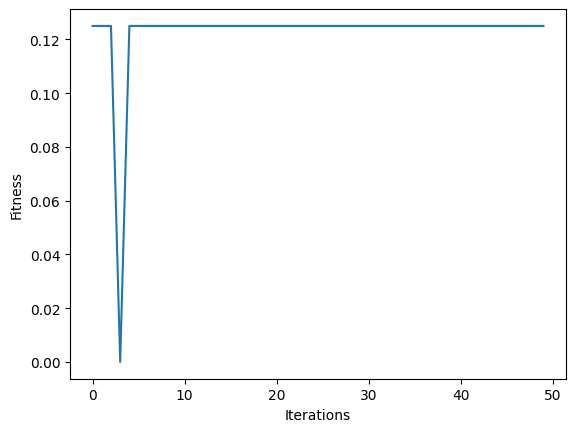

In [395]:

fig, ax = plt.subplots()
ax.plot(range(0, iters), fitnesses)
ax.set_xlabel("Iterations")
ax.set_ylabel("Fitness")